In [1]:
import numpy as np
import copy as cp
import scipy
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix
import sys
import time
import matplotlib.pyplot as plt

In [2]:
def inputamp(file_path):  #データパス
    with open(file_path, 'r') as f:
        lines = f.readlines()
        n_t = len(lines)
        ret = np.zeros((n_t+1, 2), dtype=np.float64)
        for index, line in  enumerate(lines):
            line_array = line.strip().split()
            ret[index+1, 0] = float(line_array[0])
            ret[index+1, 1] = float(line_array[1])
        return ret, n_t

In [3]:
# 要素剛性マトリックス作成（local）
def sm_3dfrm(EA,GJ,EIy,EIz,x1,y1,z1,x2,y2,z2):
    ek=np.zeros((12,12),dtype=np.float64) # local stiffness matrix
    xx=x2-x1
    yy=y2-y1
    zz=z2-z1
    el=np.sqrt(xx**2+yy**2+zz**2)
    ek[ 0, 0]= EA/el
    ek[ 0, 6]=-EA/el
    ek[ 1, 1]= 12*EIz/el**3
    ek[ 1, 5]=  6*EIz/el**2
    ek[ 1, 7]=-12*EIz/el**3
    ek[ 1,11]=  6*EIz/el**2
    ek[ 2, 2]= 12*EIy/el**3
    ek[ 2, 4]= -6*EIy/el**2
    ek[ 2, 8]=-12*EIy/el**3
    ek[ 2,10]= -6*EIy/el**2
    ek[ 3, 3]= GJ/el
    ek[ 3, 9]=-GJ/el
    ek[ 4, 2]= -6*EIy/el**2
    ek[ 4, 4]=  4*EIy/el
    ek[ 4, 8]=  6*EIy/el**2
    ek[ 4,10]=  2*EIy/el
    ek[ 5, 1]=  6*EIz/el**2
    ek[ 5, 5]=  4*EIz/el
    ek[ 5, 7]= -6*EIz/el**2
    ek[ 5,11]=  2*EIz/el
    ek[ 6, 0]=-EA/el
    ek[ 6, 6]= EA/el
    ek[ 7, 1]=-12*EIz/el**3
    ek[ 7, 5]= -6*EIz/el**2
    ek[ 7, 7]= 12*EIz/el**3
    ek[ 7,11]= -6*EIz/el**2
    ek[ 8, 2]=-12*EIy/el**3
    ek[ 8, 4]=  6*EIy/el**2
    ek[ 8, 8]= 12*EIy/el**3
    ek[ 8,10]=  6*EIy/el**2
    ek[ 9, 3]=-GJ/el
    ek[ 9, 9]= GJ/el
    ek[10, 2]= -6*EIy/el**2
    ek[10, 4]=  2*EIy/el
    ek[10, 8]=  6*EIy/el**2
    ek[10,10]=  4*EIy/el
    ek[11, 1]=  6*EIz/el**2
    ek[11, 5]=  2*EIz/el
    ek[11, 7]= -6*EIz/el**2
    ek[11,11]=  4*EIz/el
    return ek

In [6]:
def mass_3dfrm(ae_mass, npoin, nfree):
    # 番兵追加
    mass = np.append(ae_mass, 0.0)
    mass = np.insert(mass, 0, 0.0)
    ret = np.zeros((npoin*nfree, npoin*nfree), dtype=np.float64)
    node_mass_array = np.zeros(npoin, dtype=np.float64)
    for i in range(0, len(mass) - 1):
        node_mass = (mass[i] + mass[i+1]) / 2.0
        node_mass_array[i] = node_mass
        for j in range(3):
            idx = i*nfree + j
            ret[idx,idx] = node_mass
    return ret, node_mass_array

In [7]:
def dumping_3dfrm(gamma, omega, mass_mat, k):
    m = gamma * mass_mat
    ret = omega * k    
    for i in range(0, len(ret)):
        ret[i, i] += m[i, i]        
    return ret

In [8]:
# newmark マトリックスを作成
# newmarkのparam: alpha, beta
def newmark_3dfrm(delta_t, alpha, beta, k, mass_mat, c_mat): 
    return (1.0/beta/delta_t**2) * mass_mat  \
         + (alpha/beta/delta_t) * c_mat \
         + k

In [9]:
def transform_mat(theta, X, Y, Z=0):
    return np.array([[np.cos(theta), -np.sin(theta), 0, X],
                     [np.sin(theta), np.cos(theta),  0, Y],
                     [0            , 0            ,  1, Z],
                     [0            , 0            ,  0, 1]])

In [10]:
def test_3d_NEWMARK_FEM(kL, mass_mat, delta_t=0.001, n_t=1000):
        start=time.time()
        args = sys.argv        
        nod=2
        nfree=6
        alpha=0.5  # newmark param
        beta=0.25  # newmark param
        gamma=0.02 # dumping param
        omega=0.02 # dumping param
        npoin = 11
        nele = 10
        npfix = 1
                   
        mpfix = np.zeros((n_t+1, nfree, npoin), dtype=np.int)
        rdis = np.zeros((n_t+1, nfree, npoin), dtype=np.float64)
        for i in range(1, n_t+1):
            mpfix[i, 0, 0] = 1
            mpfix[i, 1, 0] = 1
            mpfix[i, 2, 0] = 1
            mpfix[i, 3, 0] = 1
            mpfix[i, 4, 0] = 1
            mpfix[i, 5, 0] = 1
            rdis[i, 0, 0] = 0
            rdis[i, 1, 0] = 0
            rdis[i, 2, 0] = 0
            rdis[i, 3, 0] = 0
            rdis[i, 4, 0] = 0
            rdis[i, 5, 0] = 0
        
        e_accL=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
        e_vecL=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
        e_disL=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)                                
          
        c_mat=dumping_3dfrm(gamma, omega, mass_mat, kL)
        newmark_mat=newmark_3dfrm(delta_t, alpha, beta, kL, mass_mat, c_mat)
        
        for step in range(1, n_t):                                                
            fL = np.zeros((nfree*npoin), dtype=np.float64)
            if step == 1:
                fL[(npoin-1)*6+1] = -10            
            
            tmp_for_mass = (1.0/beta/delta_t**2)  * e_disL[step-1] \
                         + (1.0/beta/delta_t)     * e_vecL[step-1] \
                         + ((1.0/2/beta)-1.0)     * e_accL[step-1]
            
            tmp_for_c = (alpha/beta/delta_t)            * e_disL[step-1] \
                      + ((alpha/beta)-1.0)              * e_vecL[step-1] \
                      + delta_t * ((alpha/2/beta)-1.0)  * e_accL[step-1]                        
            
            fL = fL + np.dot(mass_mat, tmp_for_mass) + np.dot(c_mat, tmp_for_c)  
            # boudary conditions
            for i in range(0, npoin):
                for j in range(0, nfree):
                    if mpfix[step, j, i] == 1:
                        iz=i*nfree+j
                        fL[iz]=0.0

            for i in range (0, npoin):
                for j in range(0, nfree):
                    if mpfix[step, j, i] == 1:
                        iz=i*nfree+j
                        newmark_mat[:,iz]=0.0
                        newmark_mat[iz,iz]=1.0
            # 疎行列圧縮格納
            sp_newmark_mat = csr_matrix(newmark_mat)
            e_disL[step] = spsolve(sp_newmark_mat, fL, use_umfpack=True)
                        
            # 拘束条件を再代入する
            for i in range(0, npoin):
                for j in range(0, nfree):
                    if mpfix[step, j, i] == 1:
                        iz=i*nfree+j
                        e_disL[step, iz] = rdis[step, j, i]
                        
            # 速度, 加速度計算            
            e_accL[step] = (1.0/beta/delta_t**2)  * (e_disL[step] - e_disL[step-1]) \
                            - (1.0/beta/delta_t)     * e_vecL[step-1] \
                            - ((1.0/2/beta)-1.0)     * e_accL[step-1]
            
            e_vecL[step] = (alpha/beta/delta_t)         * (e_disL[step] - e_disL[step-1]) \
                            + (1.0-(alpha/beta))           * e_vecL[step-1] \
                            + delta_t*(1.0-(alpha/2/beta)) * e_accL[step-1]
            
        dtime=time.time()-start
        print('time: {0:.3f}'.format(dtime)+'sec')
        return e_disL[:-1]

In [11]:
def plot_period(test_dis, save=False, title='Period'):
    step_num = test_dis.shape[0]
    nfree = 6
    node_num = test_dis.shape[1] // 6
    step = np.zeros(step_num, dtype=np.int)
    for i in range(step_num):
        step[i] = i
        
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(step, test_dis.T[(node_num-1)*6+1], label='y displacement')
    plt.title('Period')
    plt.xlabel('time [1e-3 sec]', fontsize=18)
    plt.ylabel('elastic displacement', fontsize=18)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=1, fontsize=14)
    if save:
        plt.savefig('{0}.png'.format(title))
    plt.show()
    
def calc_period_from_dis(test_dis, delta_t=0.001):
    step_num = test_dis.shape[0]
    nfree = 6
    node_num = test_dis.shape[1] // 6
    cnt = 0
    for index, y_dis in enumerate(test_dis.T[(node_num-1)*6+1]):
#         print(index, y_dis)
        if y_dis * test_dis.T[(node_num-1)*6+1][index+1] < 0:
            cnt += 1
            if (cnt == 2):
                return index*delta_t
            
def calc_period_from_kL_mass_mat(kL, mass_mat):
#     kL_eig_val, kL_eig_vec = np.linalg.eig(kL)
#     print(sorted(kL_eig_val)[:7])
    eig_val, eig_vec = scipy.linalg.eig(kL[6:, 6:], mass_mat[6:, 6:])
    w = sorted(eig_val)[0]
    T = 2 * np.pi / np.sqrt(w)
    return T

In [12]:
def get_abaqus_data(file_path, step, node_num):
    ret = np.zeros((step, node_num*6), dtype=np.float64)
    with open(file_path, 'r') as f:
        for i in range(step):
            line = '-'
            while (len(line) < 20 or line[0] != '-'):
                line = f.readline()
            for j in range(node_num):
                l = f.readline().strip().split()
                for index,ele in enumerate(l):
                    if index > 0:
                        ret[i, j*6+index-1] = float(ele)
    return ret
# get_abaqus_data('3d-beam-rot-onlyU.txt', 998, 11)

In [50]:
def print_dis(dis, ep=1):
    for i in range(len(dis)):
        if i % ep == 0:
            print(i)    
            print('ux uy uz rux ruy ruz')
            for j in range(11):                
                print(dis[i][j*6], dis[i][j*6+1], dis[i][j*6+2], dis[i][j*6+3], dis[i][j*6+4], dis[i][j*6+5])
            print('-----')
            
def plot_dis(e_disG, node_id=None, pos=None, save=False, title='displacement'):    
    step_num = e_disG.shape[0]
    nfree = 6
    node_num = disG.shape[1] // 6
    if node_id == None:
        node_id = node_num
    if pos==None:
        pos=1
    
    step = np.zeros(step_num, dtype=np.int)
    for i in range(step_num):
        step[i] = i
        
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    labels = ['x', 'y', 'z', 'rux', 'ruy', 'ruz']
    label = labels[pos]
    ax.plot(step, e_disG.T[(node_id-1)*6+pos], label='{0} node{1}'.format(label, node_id-1))
    plt.title('{0} displacement '.format(label))
    plt.xlabel('time [1e-3 sec]', fontsize=18)
    plt.ylabel('displacement', fontsize=18)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=14)
    if save:
        plt.savefig('{0}_{1}.png'.format(title, label))
    plt.show() 
# plot_dis(e_disL, 11)             
            
def print_coords(cords, ep=1):
    for i in range(len(cords)):
        if i % ep == 0:
            print(i)
            print('x: ', cords[i][0])
            print('y: ', cords[i][1])
            print('z: ', cords[i][2])
            
def plot_coords(cords, node_ids=None, save=False, title='coord'):
    step_num = cords.shape[0] - 1
    node_num = cords.shape[2]
    if node_ids == None:
        node_ids = [i+1 for i in range(node_num)]
    step = np.zeros(step_num, dtype=np.int)
    for i in range(step_num):
        step[i] = i    
    
    axises = ['x', 'y', 'z']
    for i in range(3): # x, y, z
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(1, 1, 1)
        axis = axises[i]
        for node_id in node_ids:
            data = np.zeros(step_num, dtype=np.float64)
            for k in range(step_num):
                data[k] = cords[k, i, node_id-1]
            ax.plot(step, data, label='{0} node{1}'.format(axis, node_id-1))
        plt.title('{0} displacement'.format(axis))
        plt.xlabel('time [1e-3 sec]', fontsize=18)
        plt.ylabel('coord', fontsize=18)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=14)
        if save:
            plt.savefig('{0}_{1}.png'.format(title, label))        
        plt.show()         
# plot_coods(coordsG_plus_e_dis, [11])

def print_coords(cords, ep=1):
    for i in range(len(cords)):
        if i % ep == 0:
            print(i)
            print('x: ', cords[i][0])
            print('y: ', cords[i][1])
            print('z: ', cords[i][2])
            
def plot_xy_coords(cords, node_ids=None, save=False, title='xy_coord'):
    step_num = cords.shape[0] - 1
    node_num = cords.shape[2]
    if node_ids == None:
        node_ids = [i+1 for i in range(node_num)]     
    

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    axis = axises[i]
    for node_id in node_ids:
        x_data = np.zeros(step_num, dtype=np.float64)
        y_data = np.zeros(step_num, dtype=np.float64)
        for k in range(step_num):
            x_data[k] = cords[k, 0, node_id-1]
            y_data[k] = cords[k, 1, node_id-1]

        ax.scatter(x_data, y_data, label='{0} node{1}'.format(axis, node_id-1))
        plt.title(' x-y plane coordinate'.format(axis))
        plt.xlabel('x coordinate', fontsize=18)
        plt.ylabel('y coordinate', fontsize=18)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=14)
        if save:
            plt.savefig('{0}_{1}.png'.format(title, label))        
        plt.show()
        
def plot_xy_coords_compare_with_abaqus(cords, node_ids=None, save=False, title='xy_coord'):
    step_num = cords.shape[0] - 1
    node_num = cords.shape[2]
    if node_ids == None:
        node_ids = [i+1 for i in range(node_num)]         
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    axis = axises[i]
    for node_id in node_ids:
        x_data = np.zeros(step_num, dtype=np.float64)
        y_data = np.zeros(step_num, dtype=np.float64)
        for k in range(step_num):
            x_data[k] = cords[k, 0, node_id-1]
            y_data[k] = cords[k, 1, node_id-1]

        ax.scatter(x_data, y_data, label='{0} node{1}'.format(axis, node_id-1))
        plt.title(' x-y plane coordinate'.format(axis))
        plt.xlabel('x coordinate', fontsize=18)
        plt.ylabel('y coordinate', fontsize=18)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=14)
        if save:
            plt.savefig('{0}_{1}.png'.format(title, label))        
        plt.show()        

In [79]:
def plot_compare_abaqus_dis(abaqus_dis, disG, node_ids=None, save=False, title='compare_displacement_from_origin_with_abaqus'):
    step_num = disG.shape[0]
    nfree = 6
    node_num = disG.shape[1] // 6
    if node_ids == None:
        node_ids = [i+1 for i in range(node_num)]
    step = np.zeros(step_num, dtype=np.int)
    for i in range(step_num):
        step[i] = i    
    
    labels = ['x', 'y', 'z', 'rux', 'ruy', 'ruz']
    for i in range(6): # ux, uy, uz, rux, ruy, ruz
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(1, 1, 1)
        label = labels[i]
        for node_id in node_ids:
            data = np.zeros(step_num, dtype=np.float64)
            abaqus_data = np.zeros(step_num, dtype=np.float64)
            for j in range(step_num):
                data[j] = disG[j, 6*(node_id-1)+i]
                abaqus_data[j] = abaqus_dis[j, 6*(node_id-1)+i]
            ax.plot(step, data, label='linear {0} node{1}'.format(label, node_id-1), color='blue')
            ax.plot(step, abaqus_data, label='non-linear {0} node{1}'.format(label, node_id-1), color='red')            
        plt.title('{0} displacement'.format(label))
        plt.xlabel('time [1e-3 sec]', fontsize=18)
        plt.ylabel('displacement', fontsize=18)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=14)
        if save:
            plt.savefig('{0}_{1}.png'.format(title, label))        
        plt.show()
        
def calc_dis_diff(abaqus_dis, disG, node_id=None):    
    step_num = disG.shape[0]
    nfree = 6
    node_num = disG.shape[1] // 6
    ret = {}
    if node_id == None:
        node_id = [i+1 for i in range(node_num)]    
        
    labels = ['x', 'y', 'z', 'rux', 'ruy', 'ruz']
    for nid in node_id:
        ret[nid] = {}
        for index, label in enumerate(labels):
            diff = np.abs(abaqus_dis.T[(nid-1)*6+index] - disG.T[(nid-1)*6+index])
            max_diff = np.max(diff)
            total_diff = np.sum(diff)
            average_diff = np.average(diff)
            ret[nid][label] = {}
            ret[nid][label]['max_diff'] = max_diff
            ret[nid][label]['total_diff'] = total_diff
            ret[nid][label]['average_diff'] = average_diff
    return ret
# calc_dis_diff(abaqus_dis, disG)

In [16]:
def calc_coord_e_dis(abaqus_dis, disG, coordsG):
    origin_coords = coordsG[0]
    step = disG.shape[0]
    npoin = disG.shape[1] // 6
    coords_e_dis = np.empty_like(coordsG)
    abaqus_coords_e_dis = np.empty_like(coordsG)
    for i in range(step): # i: step
        for j in range(npoin): # j: node
            for k in range(3): # 0: x, 1: y, 2: z
                coords_e_dis[i, k, j] = disG[i, j*6+k] + origin_coords[k, j]
                abaqus_coords_e_dis[i, k, j] = abaqus_dis[i, j*6+k] + origin_coords[k, j]

    return abaqus_coords_e_dis - coordsG, coords_e_dis - coordsG

In [56]:
def plot_compare_abaqus_e_dis(abaqus_coordsG_e_dis, coordsG_e_dis, node_ids=None, save=False,
                            title='compare_elastic_displacement_with_abaqus'):
    step_num = abaqus_coordsG_e_dis.shape[0]    
    node_num = abaqus_coordsG_e_dis.shape[2]
    if node_ids == None:
        node_ids = [i+1 for i in range(node_num)]
        
    step = np.zeros(step_num, dtype=np.int)
    for i in range(step_num):
        step[i] = i
    
    labels = ['x', 'y', 'z']
    for i in range(len(labels)): # x, y, z
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(1, 1, 1)
        label = labels[i]
        for node_id in node_ids:
            data = np.zeros(step_num, dtype=np.float64)
            abaqus_data = np.zeros(step_num, dtype=np.float64)
            for j in range(step_num):
                data[j] = coordsG_e_dis[j, i, node_id-1]
                abaqus_data[j] = abaqus_coordsG_e_dis[j, i, node_id-1]                
            ax.plot(step, data, label='linear {0} node{1}'.format(label, node_id-1), color='blue')
            ax.plot(step, abaqus_data, label='non-linear {0} node{1}'.format(label, node_id-1), color='red')            
        plt.title('{0} elastic displacement'.format(label))
        plt.xlabel('time [1e-3 sec]', fontsize=18)
        plt.ylabel('elastic displacement', fontsize=18)
        plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=1, fontsize=14)
        if save:
            plt.savefig('{0}_{1}.png'.format(title, label))        
        plt.show()    

In [53]:
def main_3d_NEWMARK_FEM(amp_rvz_path, amp_vx_path, amp_vy_path):
    start=time.time()
    args = sys.argv   
    nod=2
    nfree=6
    alpha=0.5  # newmark param
    beta=0.25  # newmark param
    gamma=0.02 # dumping param M
    omega=0.02 # dumping param K
    npoin = 11
    nele = 10
    npfix = 1
    delta_t = 0.001
    diameter = 0.2

    # 原点情報
    VX, _ = inputamp(amp_vx_path)
    VY, _ = inputamp(amp_vy_path)
    RVZ, n_t = inputamp(amp_rvz_path) 

    UX = np.zeros((n_t+1, 2), dtype=np.float64)
    UY = np.zeros((n_t+1, 2), dtype=np.float64)
    AX = np.zeros((n_t+1, 2), dtype=np.float64)
    AY = np.zeros((n_t+1, 2), dtype=np.float64)        

    RUZ = np.zeros((n_t+1, 2), dtype=np.float64)
    RAZ = np.zeros((n_t+1, 2), dtype=np.float64)

    AX[1, 1] = VX[1, 1] / delta_t
    AY[1, 1] = VY[1, 1] / delta_t
    RAZ[1, 1] = RVZ[1, 1] / delta_t # 初加速度

    for i in range(1, n_t+1):
        UX[i, 0] = VX[i, 0]
        AX[i, 0] = VX[i, 0]            
        UY[i, 0] = VY[i, 0]
        AY[i, 0] = VY[i, 0]
        RUZ[i, 0] = RVZ[i, 0]
        RAZ[i, 0] = RVZ[i, 0]
        if i > 1:
            UX[i, 1] = (VX[i, 1] + VX[i-1, 1])/2 * delta_t + UX[i-1, 1]
            UY[i, 1] = (VY[i, 1] + VY[i-1, 1])/2 * delta_t + UY[i-1, 1]                
            RUZ[i, 1] = (RVZ[i, 1] + RVZ[i-1, 1])/2 * delta_t + RUZ[i-1, 1]
            if i < n_t:
                AX[i, 1] = (VX[i+1, 1]-VX[i-1, 1])/2/delta_t
                AY[i, 1] = (VY[i+1, 1]-VY[i-1, 1])/2/delta_t                
                RAZ[i, 1] = (RVZ[i+1, 1]-RVZ[i-1, 1])/2/delta_t 

    #         print(UY)
    #         return
    ae = np.zeros((8, nele), dtype=np.float64)
    for i in range(nele):
        ae[0, i] = 5.42e-5 # A
        ae[1, i] = 6e-10 # I11
        ae[2, i] = 0.0 # I12
        ae[3, i] = 6e-10 # I22
        ae[4, i] = 1.93e-9 # J
        ae[5, i] = 1e11 # E
        ae[6, i] = 7.143e10 # G
        ae[7, i] = 5.42e-5 * 0.1 * 1550
    head_mass = 0.202
    node = np.zeros((nod + 1, nele), dtype=np.int)
    for i in range(nele):
        node[0, i] = i+1
        node[1, i] = i+2
        node[2, i] = i+1

    originCoordsG = np.zeros((3, npoin), dtype=np.float64)
    for i in range(npoin):
        originCoordsG[0, i] = i * 0.1 + diameter
        originCoordsG[1, i] = 0
        originCoordsG[2, i] = 0

    # x軸平行で、グリップが原点にあり、x軸正方向へbeamが伸びていると仮定したときの座標
    coordsL = np.zeros((3, npoin), dtype=np.float64)                
    coordsL_for_transform = np.zeros((4, npoin), dtype=np.float64)
    for i in range(npoin):
        coordsL[0, i] = np.sqrt(abs(originCoordsG[0, 0]-originCoordsG[0, i])**2 + \
                                abs(originCoordsG[1, 0]-originCoordsG[1, i])**2 + \
                                abs(originCoordsG[2, 0]-originCoordsG[2, i]**2))
        coordsL_for_transform[0, i] = np.sqrt(abs(originCoordsG[0, 0]-originCoordsG[0, i])**2 + \
                                              abs(originCoordsG[1, 0]-originCoordsG[1, i])**2 + \
                                              abs(originCoordsG[2, 0]-originCoordsG[2, i]**2))
        coordsL_for_transform[3, i] = 1
            
            
    mpfix = np.zeros((n_t+1, nfree, npoin), dtype=np.int)
    rdis = np.zeros((n_t+1, nfree, npoin), dtype=np.float64)
    for i in range(1, n_t+1):
        mpfix[i, 0, 0] = 1
        mpfix[i, 1, 0] = 1
        mpfix[i, 2, 0] = 1
        mpfix[i, 3, 0] = 1
        mpfix[i, 4, 0] = 1
        mpfix[i, 5, 0] = 1
        rdis[i, 0, 0] = 0
        rdis[i, 1, 0] = 0
        rdis[i, 2, 0] = 0
        rdis[i, 3, 0] = 0
        rdis[i, 4, 0] = 0
        rdis[i, 5, 0] = 0

    mass_mat, node_mass_array=mass_3dfrm(ae[7], npoin, nfree)
    # adjust head
    node_mass_array[npoin-1] += head_mass
    for i in range((npoin-1)*6, (npoin-1)*6+3):
        mass_mat[i, i] += head_mass

    e_accL=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
    e_vecL=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
    e_disL=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)        
    e_accG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
    e_vecG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)       
    e_disG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)        
    accG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)
    vecG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)       
    disG=np.zeros((n_t+1, nfree*npoin), dtype=np.float64)

    coordsG=np.zeros((n_t+1, 3, npoin), dtype=np.float64)
    coordsG_plus_e_dis=np.zeros((n_t+1, 3, npoin), dtype=np.float64)
    coordsG[0] = cp.deepcopy(originCoordsG)
    coordsG_plus_e_dis[0] = cp.deepcopy(originCoordsG)

    ir=np.zeros(nod*nfree, dtype=np.int)
    kL=np.zeros((nfree*npoin, nfree*npoin), dtype=np.float64) # Local stifness matrix
    # assembly stifness matrix & load vector
    for ne in range(nele):
        i=node[0,ne]-1
        j=node[1,ne]-1
        m=node[2,ne]-1

        x1L = coordsL[0, i]
        y1L = coordsL[1, i]
        z1L = coordsL[2, i]
        x2L = coordsL[0, j]
        y2L = coordsL[1, j]
        z2L = coordsL[2, j]

        A    =ae[0,m]  # 断面積
        I11  =ae[1,m]  # y軸周り断面二次モーメント 
        I12  =ae[2,m]  # x軸周り断面二次モーメント
        I22  =ae[3,m]  # z軸周り断面二次モーメント
        J    =ae[4,m]  # ねじり定数
        E    =ae[5,m]  # ヤング率
        G    =ae[6,m]  # せん断弾性係数
        EA=E*A
        GJ=G*J
        EIy=E*I11
        EIz=E*I22
        ekL=sm_3dfrm(EA,GJ,EIy,EIz,x1L,y1L,z1L,x2L,y2L,z2L) # local element stiffness matrix                                
        ir[11]=6*j+5; ir[10]=ir[11]-1; ir[9]=ir[10]-1; ir[8]=ir[9]-1; ir[7]=ir[8]-1; ir[6]=ir[7]-1
        ir[5] =6*i+5; ir[4] =ir[5]-1 ; ir[3]=ir[4]-1 ; ir[2]=ir[3]-1; ir[1]=ir[2]-1; ir[0]=ir[1]-1                
        # assemble
        for i in range(0, nod*nfree):
            it=ir[i]
            for j in range(0, nod*nfree):
                jt=ir[j]
                kL[it, jt] = kL[it, jt] + ekL[i,j]                                        

    c_mat=dumping_3dfrm(gamma, omega, mass_mat, kL)
    newmark_mat=newmark_3dfrm(delta_t, alpha, beta, kL, mass_mat, c_mat)

    for step in range(1, n_t):            
        vx = VX[step+1, 1]
        ux = UX[step+1, 1]
        ax = AX[step+1, 1]
        vy = VY[step+1, 1]
        uy = UY[step+1, 1]
        ay = AY[step+1, 1]
        rvz = RVZ[step+1, 1]
        ruz = RUZ[step+1, 1]
        raz = RAZ[step+1, 1]

        rot_mat = np.array(([[np.cos(ruz), -np.sin(ruz), 0.0],[np.sin(ruz), np.cos(ruz), 0.0],[0.0, 0.0, 1.0]]), dtype=np.float64)

        T_mat = transform_mat(ruz, ux+0.2, uy+0.0, 0)

        step_coordsG = np.dot(T_mat, coordsL_for_transform)[:-1]
        coordsG[step] = cp.deepcopy(step_coordsG)

        fG = np.zeros(npoin*nfree, dtype=np.float64)
        fL = np.zeros(npoin*nfree, dtype=np.float64)
        step_origin_x = step_coordsG[0, 0]
        step_origin_y = step_coordsG[1, 0]
        step_origin_z = step_coordsG[2, 0]
        for i in range(npoin):
            step_coordG_x = step_coordsG[0, i]
            step_coordG_y = step_coordsG[1, i]
            step_coordG_z = step_coordsG[2, i]
            r = np.sqrt(abs(step_coordG_x - step_origin_x)**2 + abs(step_coordG_y - step_origin_y)**2 + abs(step_coordG_z - step_origin_z)**2)
            axG = ax - r * (raz*np.sin(ruz) + (rvz**2)*np.cos(ruz))
            ayG = ay + r * (raz*np.cos(ruz) - (rvz**2)*np.sin(ruz))
            azG = 0
            node_mass = node_mass_array[i]
            fxG = -node_mass*axG
            fyG = -node_mass*ayG
            fzG = 0
            fG[i*6 + 0] = fxG
            fG[i*6 + 1] = fyG
            fG[i*6 + 2] = fzG
            fL[i*6 + 0] = 0
            fL[i*6 + 1] = fyG * np.cos(ruz) - fxG * np.sin(ruz)
            fL[i*6 + 2] = fzG
#             print(fL)            

        tmp_for_mass = (1.0/beta/delta_t**2)  * e_disL[step-1] \
                     + (1.0/beta/delta_t)     * e_vecL[step-1] \
                     + ((1.0/2/beta)-1.0)     * e_accL[step-1]

        tmp_for_c = (alpha/beta/delta_t)            * e_disL[step-1] \
                  + ((alpha/beta)-1.0)              * e_vecL[step-1] \
                  + delta_t * ((alpha/2/beta)-1.0)  * e_accL[step-1]                        

        fL += np.dot(mass_mat, tmp_for_mass) + np.dot(c_mat, tmp_for_c)  
        # boudary conditions
        for i in range(0, npoin):
            for j in range(0, nfree):
                if mpfix[step, j, i] == 1:
                    iz=i*nfree+j
                    fL[iz]=0.0

        for i in range (0, npoin):
            for j in range(0, nfree):
                if mpfix[step, j, i] == 1:
                    iz=i*nfree+j
                    newmark_mat[:,iz]=0.0
                    newmark_mat[iz,iz]=1.0
        # 疎行列圧縮格納
        sp_newmark_mat = csr_matrix(newmark_mat)
        e_disL[step] = spsolve(sp_newmark_mat, fL, use_umfpack=True)

        # 拘束条件を再代入する
        for i in range(0, npoin):
            for j in range(0, nfree):
                if mpfix[step, j, i] == 1:
                    iz=i*nfree+j
                    e_disL[step, iz] = rdis[step, j, i]

        # 速度, 加速度計算            
        e_accL[step] = (1.0/beta/delta_t**2)  * (e_disL[step] - e_disL[step-1]) \
                        - (1.0/beta/delta_t)     * e_vecL[step-1] \
                        - ((1.0/2/beta)-1.0)     * e_accL[step-1]

        e_vecL[step] = (alpha/beta/delta_t)         * (e_disL[step] - e_disL[step-1]) \
                        + (1.0-(alpha/beta))           * e_vecL[step-1] \
                        + delta_t*(1.0-(alpha/2/beta)) * e_accL[step-1]

        e_disG[step] = cp.deepcopy(e_disL[step])

        for i in range(npoin):
            e_disG[step][i*6:i*6+3] = np.dot(rot_mat, e_disG[step][i*6:i*6+3])

            coordsG_plus_e_dis[step, 0, i] = coordsG[step, 0, i] + e_disG[step-1][i*6]
            coordsG_plus_e_dis[step, 1, i] = coordsG[step, 1, i] + e_disG[step-1][i*6+1]
            coordsG_plus_e_dis[step, 2, i] = coordsG[step, 2, i] + e_disG[step-1][i*6+2]                  

            disG[step][i*6  ] = coordsG_plus_e_dis[step][0][i] - originCoordsG[0][i] # dis_x
            disG[step][i*6+1] = coordsG_plus_e_dis[step][1][i] - originCoordsG[1][i] # dis_y
            disG[step][i*6+2] = coordsG_plus_e_dis[step][2][i] - originCoordsG[2][i] # dis_z                
            disG[step][i*6+5] = e_disG[step-1][i*6+5] + ruz # ruz
#             if (step % 10 == 0):
#                 step_time = time.time()-start
#                 print('{0} step: {1:.3f}'.format(step, step_time))
    # print out result
    dtime=time.time()-start
    print('time: {0:.3f}'.format(dtime)+'sec')
    return e_disL[:-1], e_disG[:-1], disG[:-1], coordsG_plus_e_dis[:-1], coordsG[:-1], kL, mass_mat

In [19]:
e_disL, e_disG, disG, coordsG_plus_dis, coordsG, kL, mass_mat = \
main_3d_NEWMARK_FEM('amp_rvz_等角加速度_3sec_3000step_180deg.txt',
                   'amp_vx_半径0.6_3sec_3000step_180deg.txt',
                   'amp_vy_半径0.6_3sec_3000step_180deg.txt')

time: 2.491sec


In [20]:
test_dis = test_3d_NEWMARK_FEM(kL, mass_mat)

time: 0.532sec


In [21]:
calc_period_from_dis(test_dis)

0.231

In [22]:
calc_period_from_kL_mass_mat(kL, mass_mat)

(0.22068909578747942+0j)

In [23]:
e_disL2, e_disG2, disG2, coordsG_plus_dis2, coordsG2, _, _ = \
main_3d_NEWMARK_FEM('amp_rvz_等角加速度_1sec_1000step_180deg.txt',
                   'amp_vx_半径0.6_1sec_1000step_180deg.txt',
                   'amp_vy_半径0.6_1sec_1000step_180deg.txt')

time: 0.874sec


In [25]:
# e_disL3, e_disG3, disG3, coordsG_plus_dis3, coordsG3, _, _ = \
# main_3d_NEWMARK_FEM('amp_rvz_等角加速度_0.6sec_600step_180deg.txt',
#                    'amp_vx_半径0.6_0.6sec_600step_180deg.txt',
#                    'amp_vy_半径0.6_0.6sec_600step_180deg.txt')

In [26]:
e_disL4, e_disG4, disG4, coordsG_plus_dis4, coordsG4, _, _ = \
main_3d_NEWMARK_FEM('amp_rvz_等角加速度_0.3sec_300step_180deg.txt',
                   'amp_vx_半径0.6_0.3sec_300step_180deg.txt',
                   'amp_vy_半径0.6_0.3sec_300step_180deg.txt')

time: 0.285sec


In [27]:
abaqus_dis = get_abaqus_data('2d-beam-3secU.txt', 3000, 11)
abaqus_dis2 = get_abaqus_data('2d-beam-1secU.txt', 1000, 11)
# abaqus_dis3 = get_abaqus_data('beam05U.txt', 600, 11)
abaqus_dis4 = get_abaqus_data('2d-beam-0.3secU.txt', 300, 11)

In [38]:
abaqus_coordsG_e_dis, coordsG_e_dis = calc_coord_e_dis(abaqus_dis, disG, coordsG)
abaqus_coordsG_e_dis2, coordsG_e_dis2 = calc_coord_e_dis(abaqus_dis2, disG2, coordsG2)
# abaqus_coordsG_e_dis3, coordsG_e_dis3 = calc_coord_e_dis(abaqus_dis3, disG3, coordsG3)
abaqus_coordsG_e_dis4, coordsG_e_dis4 = calc_coord_e_dis(abaqus_dis4, disG4, coordsG4)

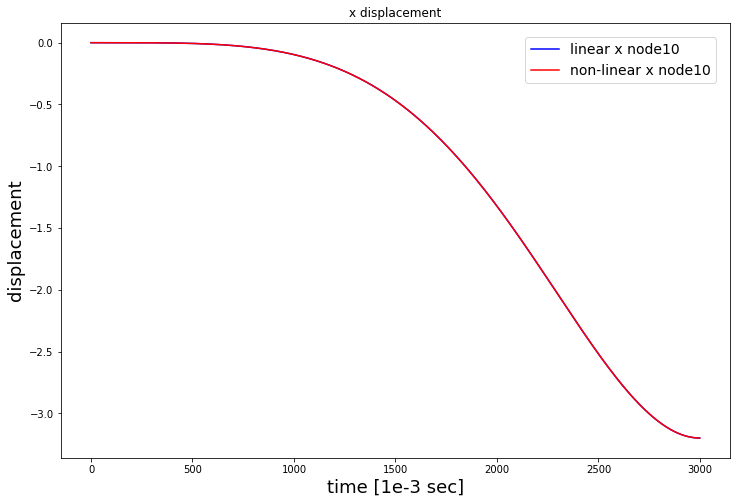

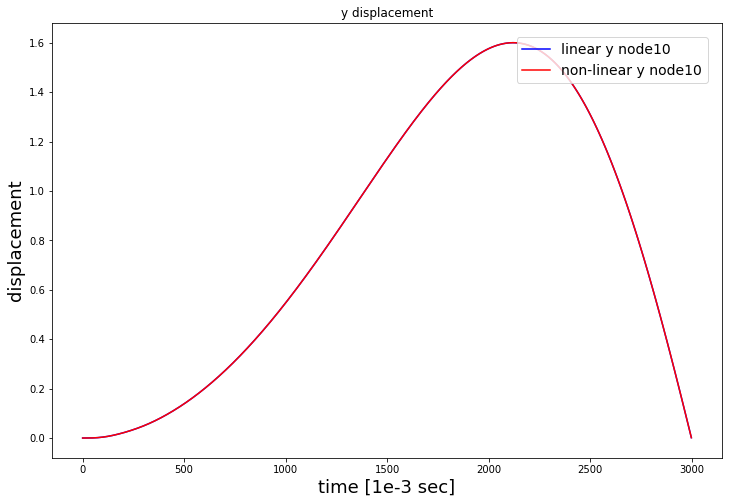

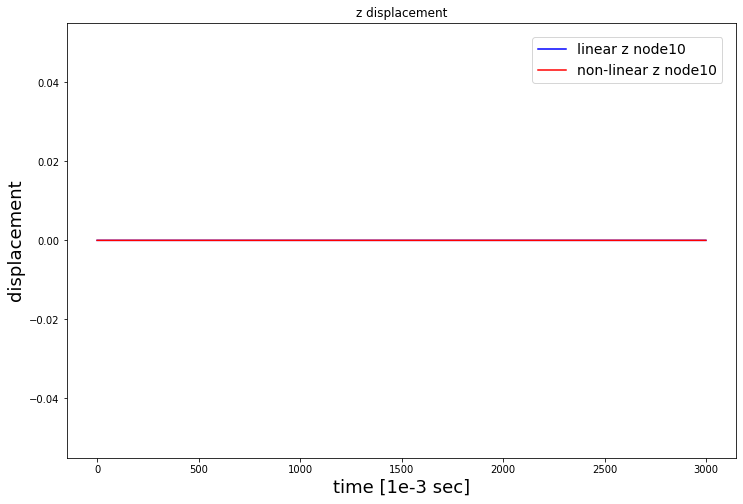

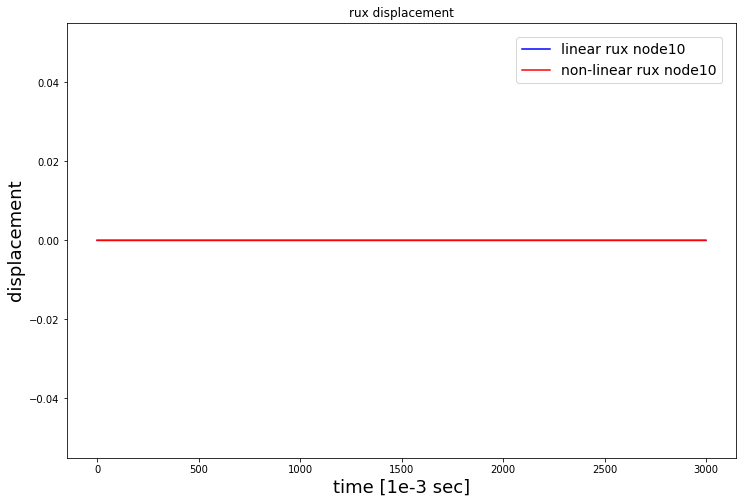

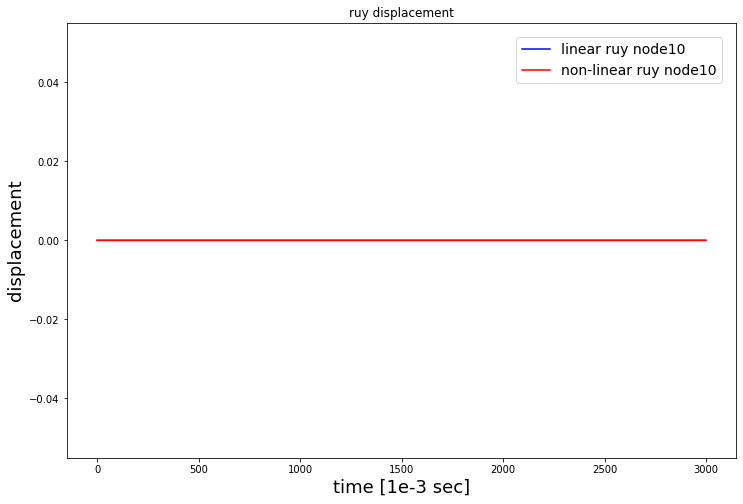

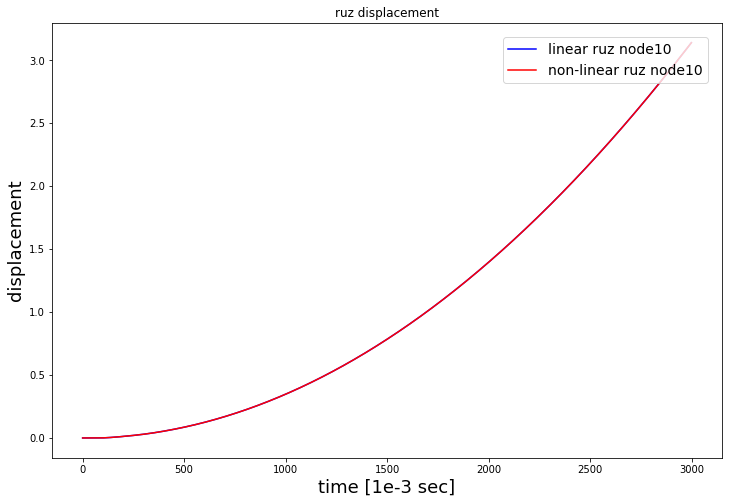

In [54]:
plot_compare_abaqus_dis(abaqus_dis, disG, [11], True, '3sec-total-dis')

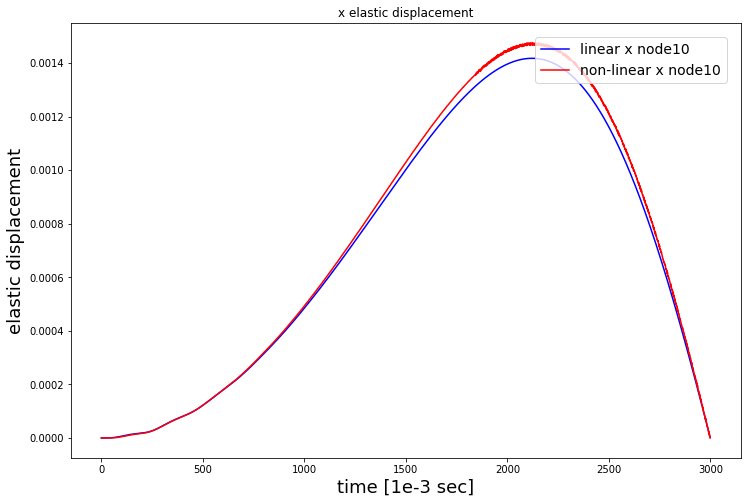

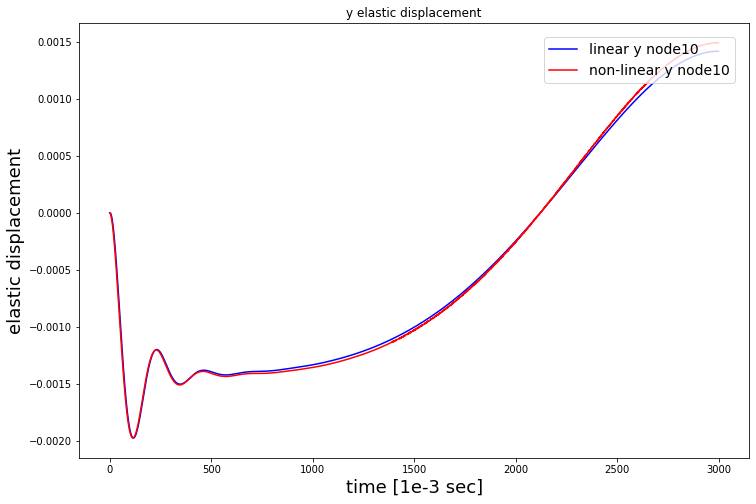

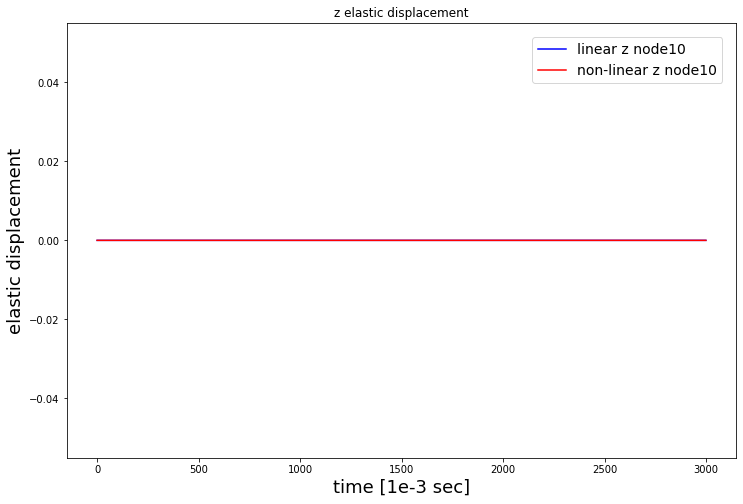

In [57]:
plot_compare_abaqus_e_dis(abaqus_coordsG_e_dis, coordsG_e_dis, [11], True, '3sec-edis')

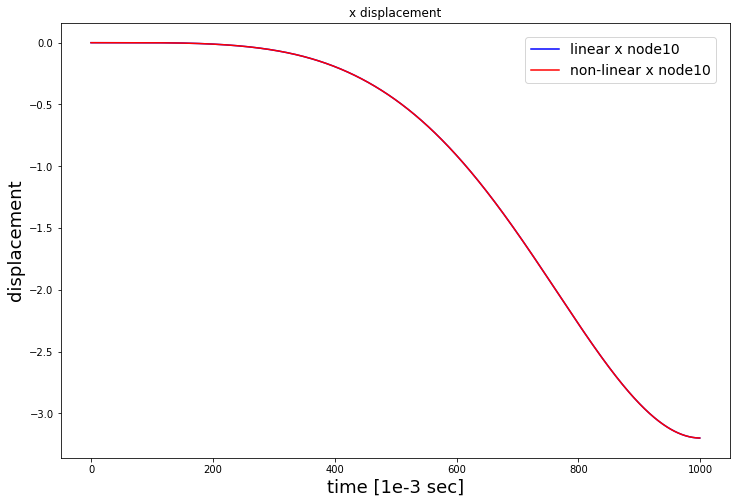

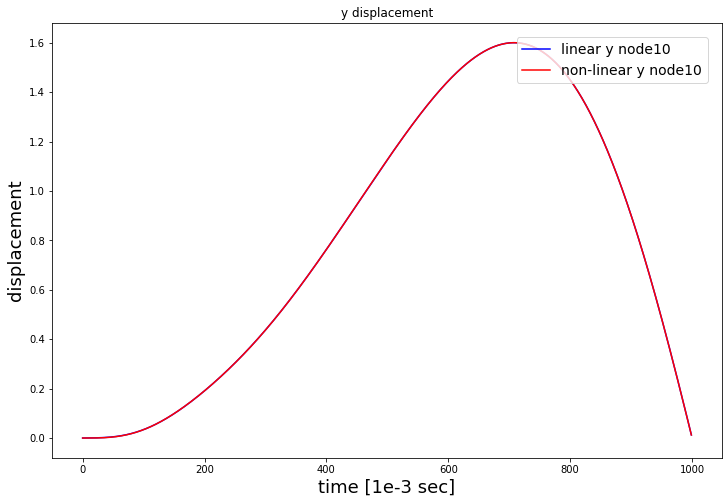

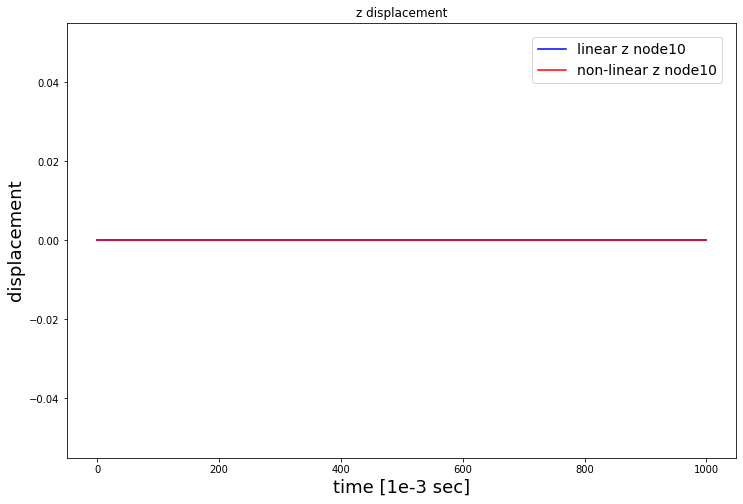

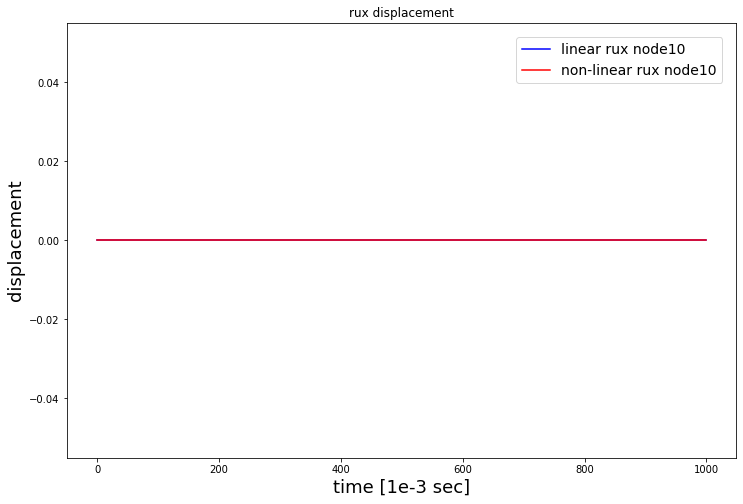

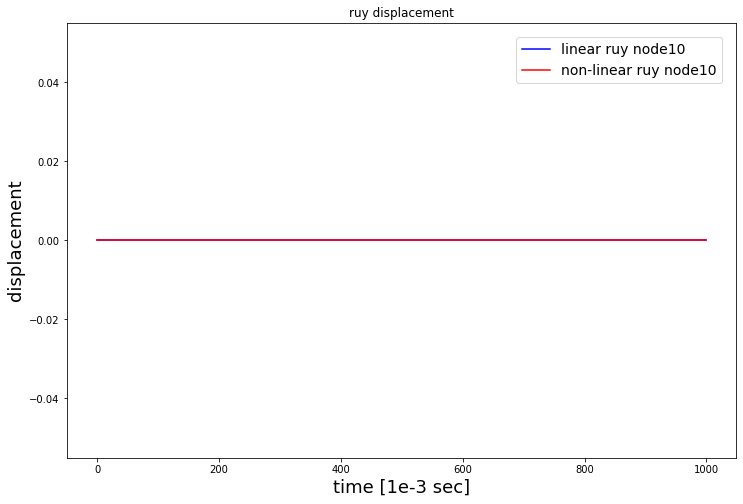

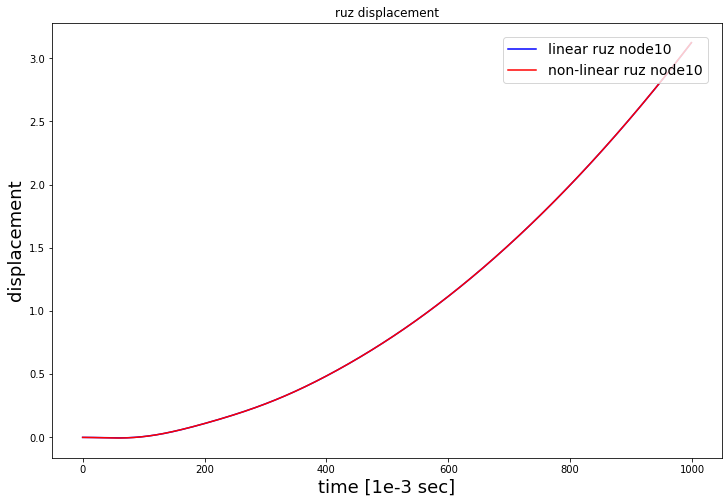

In [58]:
plot_compare_abaqus_dis(abaqus_dis2, disG2, [11], True, '1sec-total-dis')

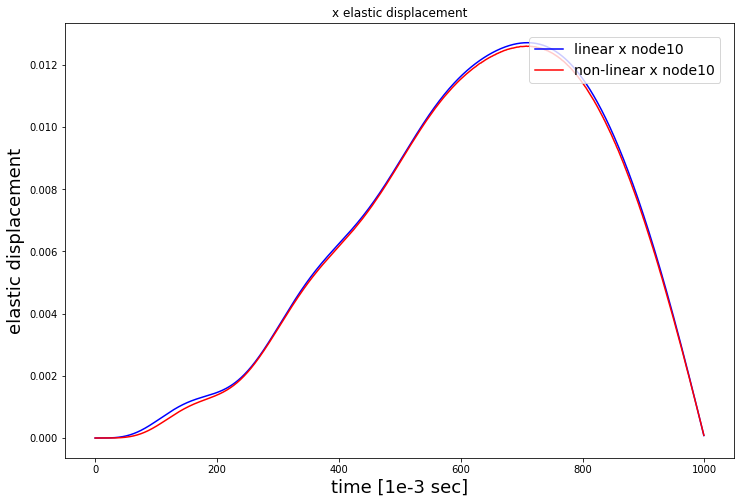

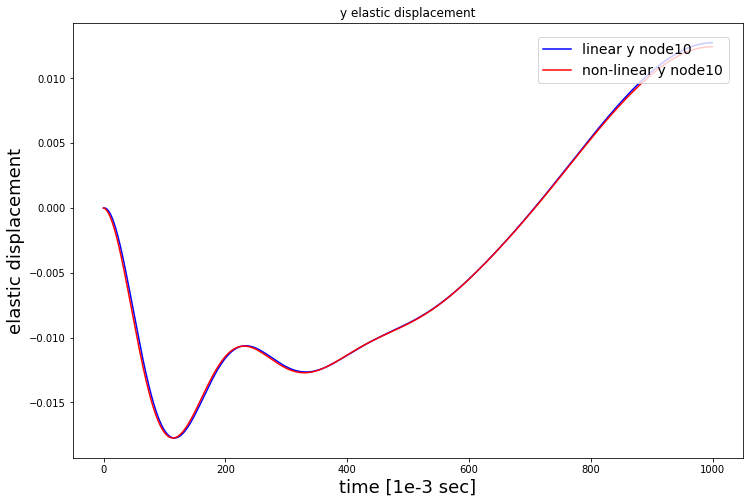

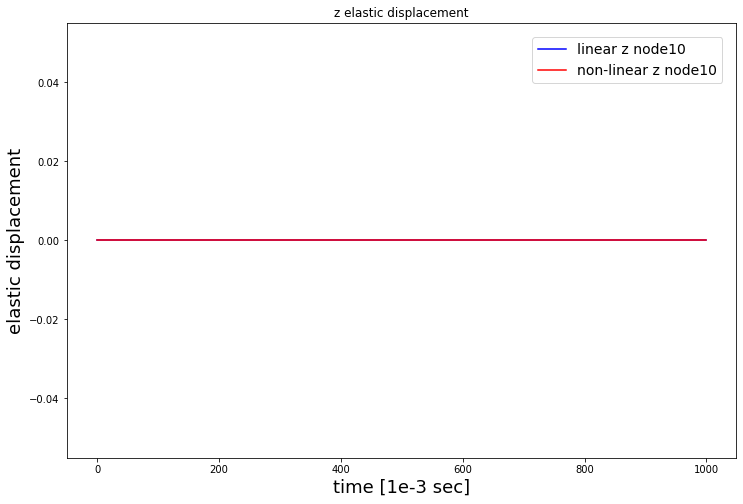

In [59]:
plot_compare_abaqus_e_dis(abaqus_coordsG_e_dis2, coordsG_e_dis2, [11], True,'1sec-edis')

In [49]:
# plot_compare_abaqus_dis(abaqus_dis3, disG3, [11])

In [51]:
# plot_compare_abaqus_e_dis(abaqus_coordsG_e_dis3, coordsG_e_dis3, [11])

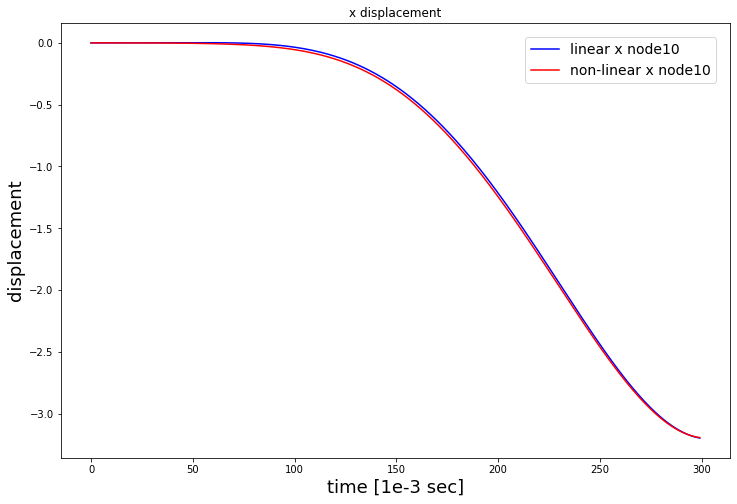

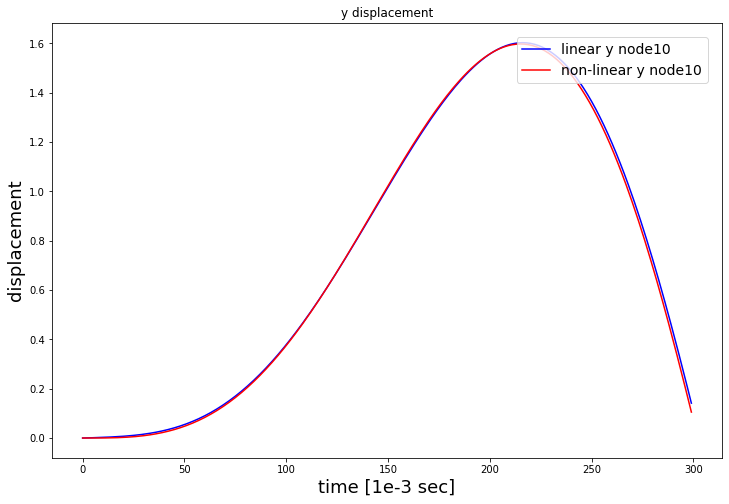

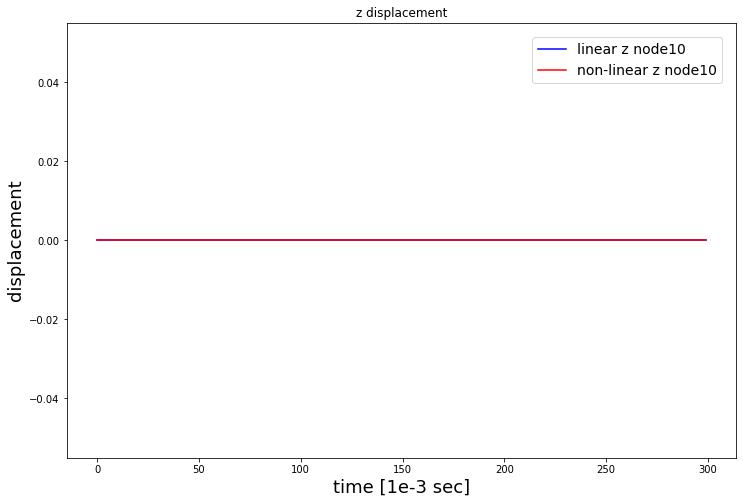

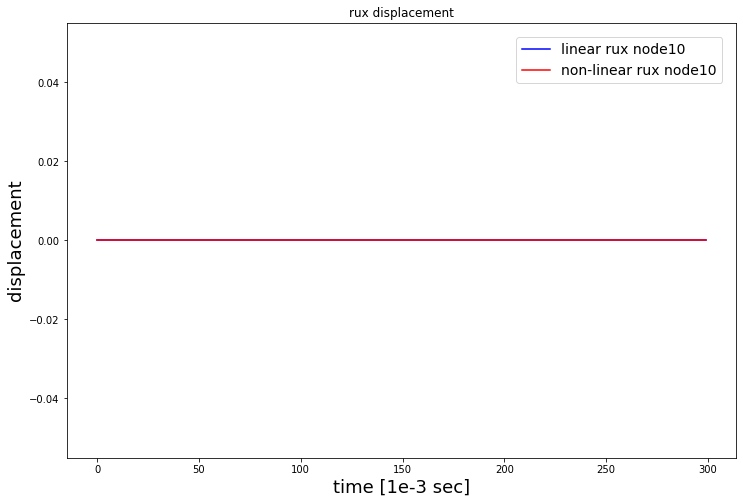

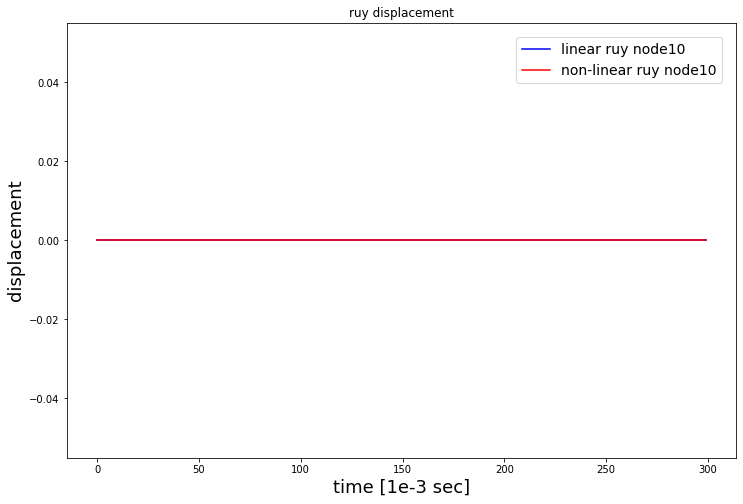

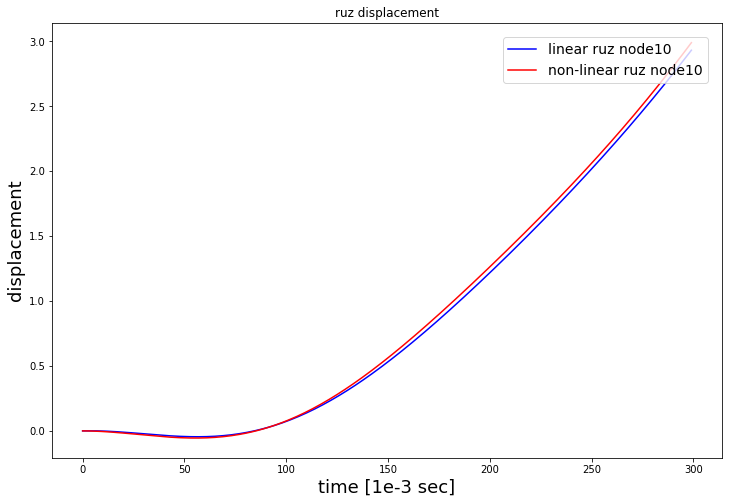

In [60]:
plot_compare_abaqus_dis(abaqus_dis4, disG4, [11], True, '03sec-total-dis')

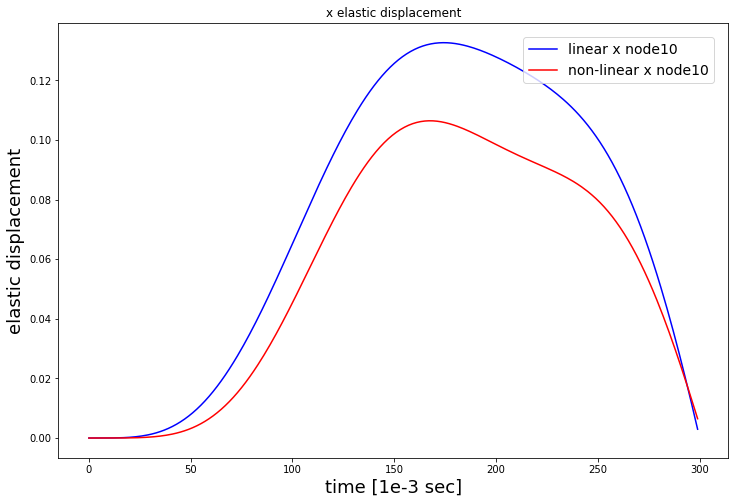

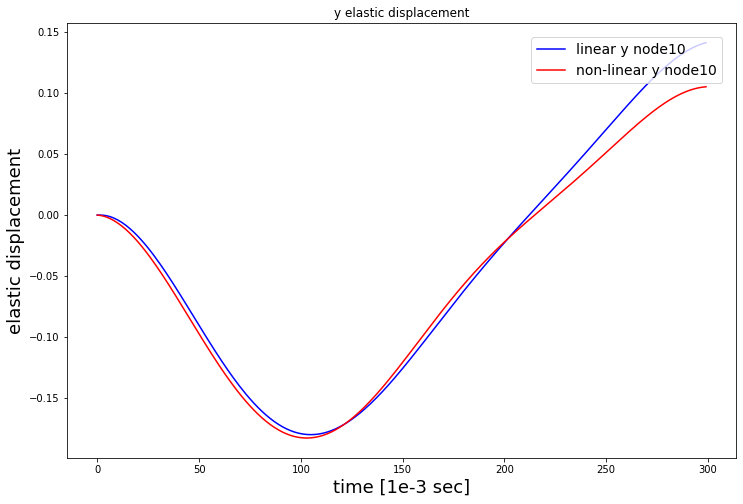

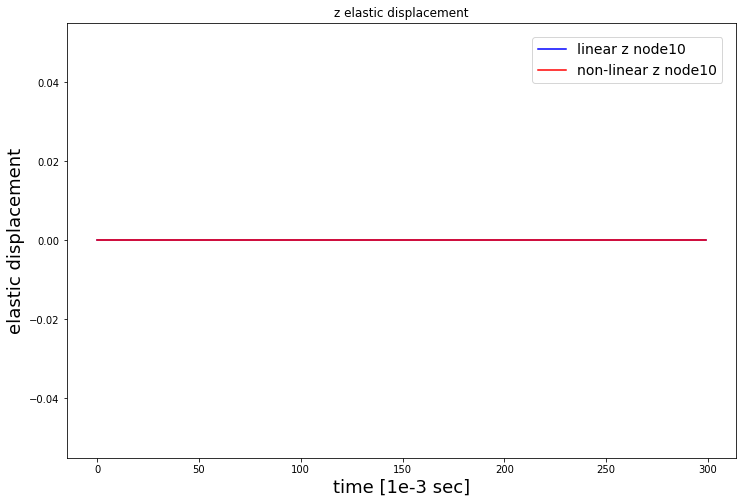

In [61]:
plot_compare_abaqus_e_dis(abaqus_coordsG_e_dis4, coordsG_e_dis4, [11], True, '03sec-edis')

In [47]:
0.2642763 / 0.0026695

98.99842667166136

In [80]:
diff = calc_dis_diff(abaqus_dis, disG, [11])
diff2 = calc_dis_diff(abaqus_dis2, disG2, [11])
diff4 = calc_dis_diff(abaqus_dis4, disG4, [11])

In [85]:
diff4

{11: {'x': {'max_diff': 0.02941735968479975,
   'total_diff': 4.97553849269099,
   'average_diff': 0.016585128308969965},
  'y': {'max_diff': 0.03614363098172621,
   'total_diff': 2.695977230162882,
   'average_diff': 0.008986590767209608},
  'z': {'max_diff': 0.0, 'total_diff': 0.0, 'average_diff': 0.0},
  'rux': {'max_diff': 0.0, 'total_diff': 0.0, 'average_diff': 0.0},
  'ruy': {'max_diff': 0.0, 'total_diff': 0.0, 'average_diff': 0.0},
  'ruz': {'max_diff': 0.05800316007631734,
   'total_diff': 8.13646696666881,
   'average_diff': 0.027121556555562698}}}

In [73]:
def calc_dis_diff(abaqus_dis, disG, node_id=None):    
    step_num = disG.shape[0]
    nfree = 6
    node_num = disG.shape[1] // 6
    ret = {}
    if node_id == None:
        node_id = [i+1 for i in range(node_num)]    
        
    labels = ['x', 'y', 'z', 'rux', 'ruy', 'ruz']
    for nid in node_id:
        ret[nid] = {}
        for index, label in enumerate(labels):
            diff = np.abs(abaqus_dis.T[(nid-1)*6+index] - disG.T[(nid-1)*6+index])
            return diff
            max_diff = np.max(diff)
            total_diff = np.sum(diff)
            average_diff = np.average(diff)
            ret[nid][label] = {}
            ret[nid][label]['max_diff'] = max_diff
            ret[nid][label]['total_diff'] = max_diff
            ret[nid][label]['average_diff'] = max_diff
    return ret

In [74]:
diff = calc_dis_diff(abaqus_dis, disG, [11])


In [77]:
np.max(diff)

6.056377024599158e-05

In [78]:
np.average(diff)

2.380264536332456e-05